<a href="https://colab.research.google.com/github/San-lab-ship/Deteccion-de-Fraude-en-Transacciones-Financieras/blob/main/Detecci%C3%B3n_de_Fraude_en_Transacciones_Financieras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:52:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


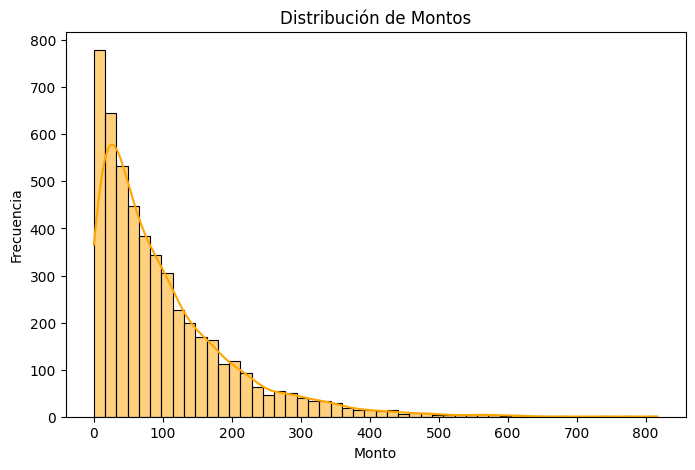

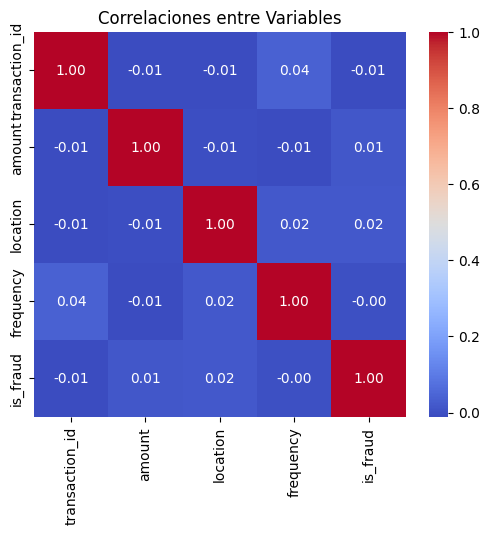

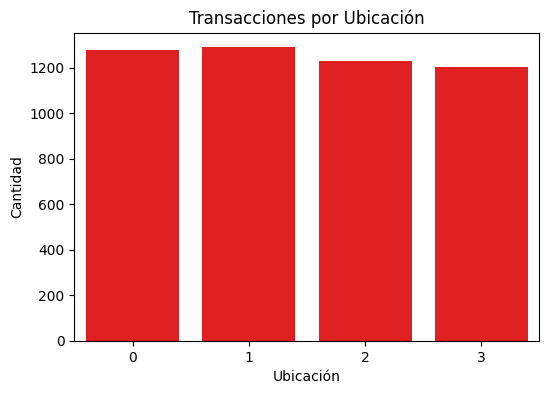

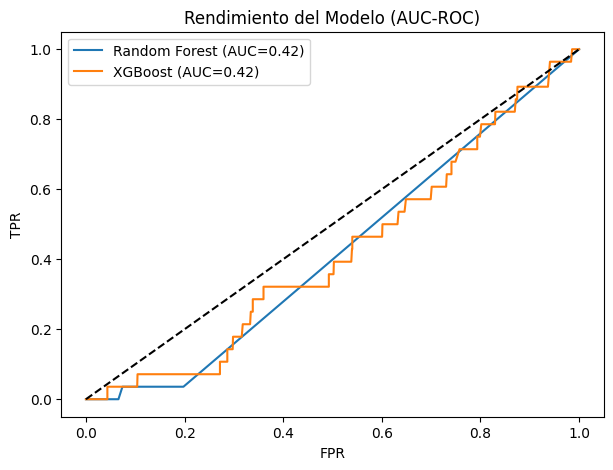

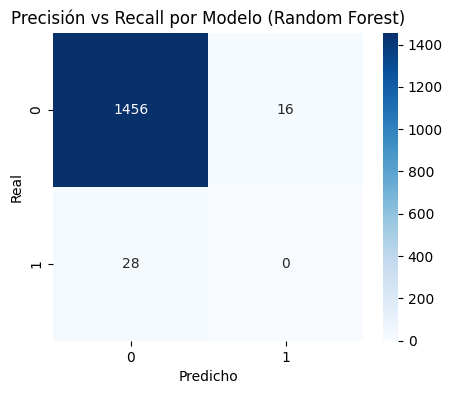

Random Forest: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'ROC-AUC': np.float64(0.4945652173913043)}
XGBoost: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'ROC-AUC': np.float64(0.49966032608695654)}
Isolation Forest: {'Precision': 0.030303030303030304, 'Recall': 0.03571428571428571, 'F1-score': 0.03278688524590164, 'ROC-AUC': np.float64(0.5069875776397516)}


In [5]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

# -----------------------------
# 1️⃣ Extracción de datos (simulada)
# -----------------------------
np.random.seed(42)
n = 5000
df = pd.DataFrame({
    'transaction_id': range(n),
    'amount': np.random.exponential(scale=100, size=n),
    'location': np.random.choice(['CiudadA', 'CiudadB', 'CiudadC', 'CiudadD'], n),
    'frequency': np.random.poisson(2, n),
    'is_fraud': np.random.choice([0, 1], n, p=[0.98, 0.02])
})

# -----------------------------
# 2️⃣ Preprocesamiento
# -----------------------------
le = LabelEncoder()
df['location'] = le.fit_transform(df['location'])

X = df.drop(['transaction_id', 'is_fraud'], axis=1)
y = df['is_fraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# -----------------------------
# 3️⃣ Entrenamiento de modelos
# -----------------------------
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

# Isolation Forest
iso = IsolationForest(contamination=0.02, random_state=42)
iso.fit(X_train)
y_pred_iso = iso.predict(X_test)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1)

# -----------------------------
# 4️⃣ Visualizaciones
# -----------------------------
# 4.1 Histogramas de montos de transacciones – "Distribución de Montos"
plt.figure(figsize=(8,5))
sns.histplot(df['amount'], bins=50, kde=True, color='orange')
plt.title("Distribución de Montos")
plt.xlabel("Monto")
plt.ylabel("Frecuencia")
plt.show()

# 4.2 Heatmap de correlación – "Correlaciones entre Variables"
plt.figure(figsize=(6,5))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlaciones entre Variables")
plt.show()

# 4.3 Conteo de transacciones por ubicación – "Transacciones por Ubicación"
plt.figure(figsize=(6,4))
sns.countplot(x='location', data=df, color='red')
plt.title("Transacciones por Ubicación")
plt.xlabel("Ubicación")
plt.ylabel("Cantidad")
plt.show()

# 4.4 Curva ROC – "Rendimiento del Modelo (AUC-ROC)"
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test,y_proba_rf):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test,y_proba_xgb):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.title("Rendimiento del Modelo (AUC-ROC)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# 4.5 Matriz de Confusión – "Precisión vs Recall por Modelo (Random Forest)"
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Precisión vs Recall por Modelo (Random Forest)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# -----------------------------
# 5️⃣ Métricas de evaluación
# -----------------------------
def evaluate_model(y_true, y_pred):
    return {
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred)
    }

print("Random Forest:", evaluate_model(y_test, y_pred_rf))
print("XGBoost:", evaluate_model(y_test, y_pred_xgb))
print("Isolation Forest:", evaluate_model(y_test, y_pred_iso))
